<center>
<h1> SOLUCIÓN TAREA 6 - Restauración de Imágenes
</h1>
<h3>Diego Godoy Rojas & Luis Carlos Diaz </h3>
</center>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import gaussian, convolve2d
from skimage import color, data, restoration
from numpy.fft import fft2, ifft2
import matplotlib
from math import exp, pow

<h1>PRIMER PUNTO

En este punto se desarrollara el filtro de rechazo Notch ideal, Butterworth y gaussiano para unas imagenes que en frecuencia tienen patrones defrecuencias en vecindarios predefinidos con respecto al centro de frecuencia.

<h2>Imagen en frecuencia

In [2]:
def get_fshift_and_save_dft(img):
    img = np.asarray(img)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    dft = 20 * np.log(np.abs(fshift))
    return fshift, dft

<h2>Filtro de rechazo Notch Ideal

In [3]:
def IdealNotchFilter(img, points, d0):
    fshift,dft =get_fshift_and_save_dft(img) 
    m = fshift.shape[0]
    n = fshift.shape[1]
    for u in range(m):
        for v in range(n):
            for d in range(len(points)):
                u0 = points[d][0]
                v0 = points[d][1]
                u0, v0 = v0, u0
                d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 1)
                d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 1)
                if d1 <= d0 or d2 <= d0:
                    fshift[u][v] *= 0.00
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

<h2>Filtro de rechazo Notch Butterworth

In [4]:
def ButterworthNotchFilter(img, points, d0, order = 1):
    fshift,dft =get_fshift_and_save_dft(img) 
    m = fshift.shape[0]
    n = fshift.shape[1]
    for u in range(m):
        for v in range(n):
            for d in range(len(points)):
                u0 = points[d][0]
                v0 = points[d][1]
                u0, v0 = v0, u0
                d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 0.5)
                d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 0.5)
                if d1 * d2 == 0:
                    fshift[u][v] = 0
                elif (1 + pow((d0 * d0) / (d1 * d2), order)) == 0:
                    fshift[u][v] = 0
                else:
                    fshift[u][v] *= (1.0 / (1 + pow((d0 * d0) / (d1 * d2), order))) 

    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

<h2>Filtro de rechazo Notch Gaussiano

In [9]:
def GaussianNotchFilter(img, points, d0):   
    fshift,dft =get_fshift_and_save_dft(img) 
    m = fshift.shape[0]
    n = fshift.shape[1]
    for u in range(m):
        for v in range(n):
            for d in range(len(points)):
                u0 = points[d][0]
                v0 = points[d][1]
                u0, v0 = v0, u0
                d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 0.5)
                d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 0.5)
                fshift[u][v] *= (1 - exp(-0.5 * (d1 * d2 / pow(d0, 2))))
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

Una vez definidos nuestros tres filtros procedemos a cargar la imagen, hallamos su transformada en frecuencia y veremos como son los patrones de interferencia que presenta:

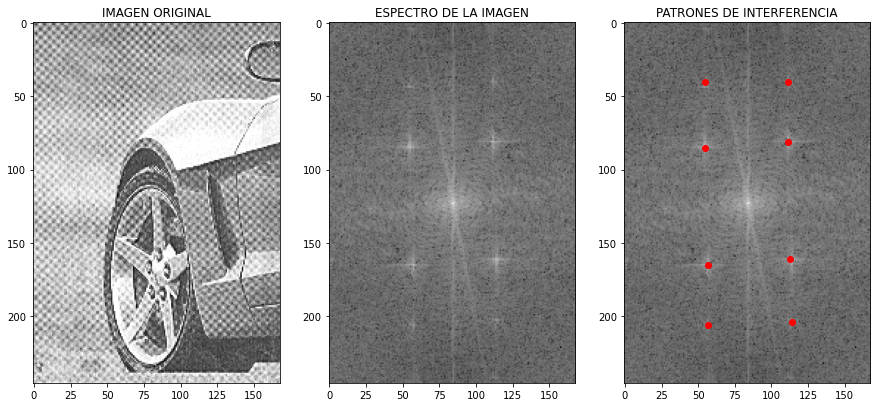

In [87]:
img = cv2.imread("fig/carro.jpg",0) #EMPEZAMOS CARGANDO LA IMAGEN
plt.figure(1,figsize=(15,10))
plt.subplot(131)
plt.imshow(img, cmap="gray")
plt.title('IMAGEN ORIGINAL')
plt.subplot(132)
plt.imshow(get_fshift_and_save_dft(img)[1], cmap="gray")
plt.title('ESPECTRO DE LA IMAGEN')
#cv2.imwrite("imgOriginl.tiff",get_fshift_and_save_dft(img)[1])
plt.subplot(133)
plt.imshow(get_fshift_and_save_dft(img)[1], cmap="gray")
plt.title('PATRONES DE INTERFERENCIA')
points =[[55,85],[111,81],[111,40],[55,40],[57,165],[113,161],[57,206],[114,204]]
points = np.asarray(points)
plt.scatter(x=points[:,0],y=points[:,1],color='red', marker='o')
#cv2.imwrite("imgOriginl.tiff",get_fshift_and_save_dft(img)[1])

Como podemos observar la imagen tiene diversos patrones de interferencia, en esta instancia nos centraremos en los 8 puntos señalados para comprobar el comportamiento de nuestros filtros:

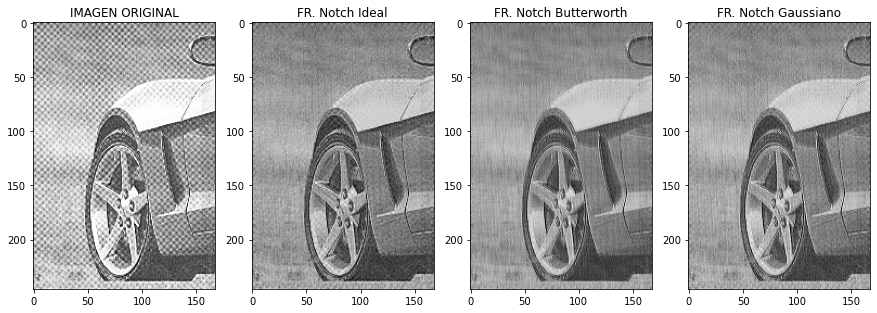

In [24]:
points =[[55,85],[111,81],[111,40],[55,40],[57,165],[113,161],[57,206],[114,204]] #Definimos los 8 puntos observados
points = np.asarray(points)
d0=70 # Frecuencia
plt.figure(1,figsize=(15,15))
plt.subplot(141)
plt.imshow(img, cmap="gray")
plt.title('IMAGEN ORIGINAL')
plt.subplot(142)
plt.title('FR. Notch Ideal')
plt.imshow(IdealNotchFilter(img, points, d0), cmap="gray")
plt.subplot(143)
plt.title('FR. Notch Butterworth')
plt.imshow(ButterworthNotchFilter(img, points, d0, order = 3), cmap="gray")
plt.subplot(144)
plt.title('FR. Notch Gaussiano')
plt.imshow(GaussianNotchFilter(img, points, 50), cmap="gray")

De  esta manera podemos comprobar el debido funcionamiento de nuestros filtros para filtrar los patrones de interferencia, siendo el de mejor comportamiento el definido como ideal, sin embargo podemos observar como a los bordes aun sigue existiendo un poco de intergerencia, esto se debe a que nos centramos en las 8 interferencias principales, entonces para mejorar el desempeño podriamos definir mas puntos y de esta manera eliminar mas interferencias.

Ahora bien probemos nuestros filtros con un patron de interferencia un poco diferente:

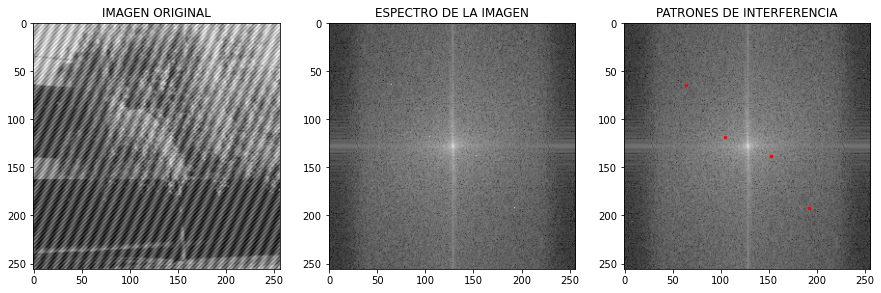

In [92]:
plt.figure(1,figsize=(15,10))
img = cv2.imread("fig/arbol.png",0)
plt.subplot(131)
plt.imshow(img, cmap="gray")
plt.title('IMAGEN ORIGINAL')
plt.subplot(132)
plt.imshow(get_fshift_and_save_dft(img)[1], cmap="gray")
plt.title('ESPECTRO DE LA IMAGEN')
#cv2.imwrite("imgOriginl.tiff",get_fshift_and_save_dft(img)[1])
plt.subplot(133)
plt.imshow(get_fshift_and_save_dft(img)[1], cmap="gray")
plt.title('PATRONES DE INTERFERENCIA')
points =[[64,64],[104,118],[152,138],[192,192]]
points = np.asarray(points)
plt.scatter(x=points[:,0],y=points[:,1],color='red', marker='o',s=6)
#cv2.imwrite("imgOriginl.tiff",get_fshift_and_save_dft(img)[1])

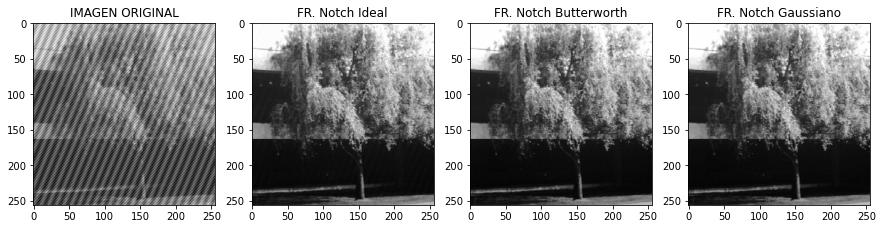

In [33]:
points =[[64,64],[104,118],[152,138],[192,192]]
points = np.asarray(points)
d0=5 # Frecuencia
plt.figure(1,figsize=(15,15))
plt.subplot(141)
plt.imshow(img, cmap="gray")
plt.title('IMAGEN ORIGINAL')
plt.subplot(142)
plt.title('FR. Notch Ideal')
plt.imshow(IdealNotchFilter(img, points, d0), cmap="gray")
plt.subplot(143)
plt.title('FR. Notch Butterworth')
plt.imshow(ButterworthNotchFilter(img, points, d0, order = 3), cmap="gray")
plt.subplot(144)
plt.title('FR. Notch Gaussiano')
plt.imshow(GaussianNotchFilter(img, points, d0), cmap="gray")

Como podemos observar al centrarnos puntualmente todos los patronos de interferencia presentes obtenemos un desempeño mejor para nuestros filtros.

Por ultimo examinaremos una imagen mas compleja, pues ademas de tener interferencia tambien esta degradada:

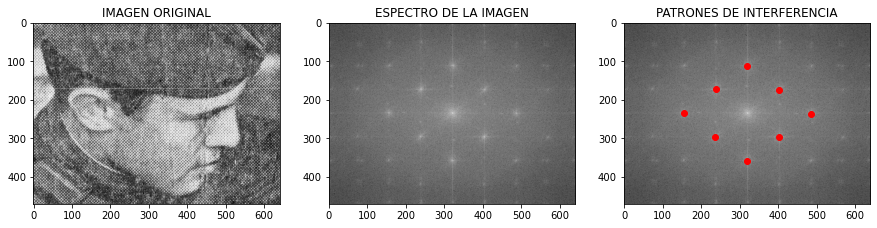

In [89]:
img = cv2.imread("fig/hombre.jpg",0)
plt.figure(1,figsize=(15,10))
plt.subplot(131)
plt.imshow(img, cmap="gray")
plt.title('IMAGEN ORIGINAL')
plt.subplot(132)
plt.imshow(get_fshift_and_save_dft(img)[1], cmap="gray")
plt.title('ESPECTRO DE LA IMAGEN')
#cv2.imwrite("imgOriginl.tiff",get_fshift_and_save_dft(img)[1])
plt.subplot(133)
plt.imshow(get_fshift_and_save_dft(img)[1], cmap="gray")
plt.title('PATRONES DE INTERFERENCIA')
points =[[320,112],[238,173],[403,174],[154,235],[485,236],[236,296],[401,297],[319,358]]
points = np.asarray(points)
plt.scatter(x=points[:,0],y=points[:,1],color='red', marker='o')
#cv2.imwrite("imgOriginl.tiff",get_fshift_and_save_dft(img)[1])

En esta ocasión podemos ver como los patrones de interferencia se distribuyen por toda la imagen, lo que hace mucho mas complejo su filtrado:

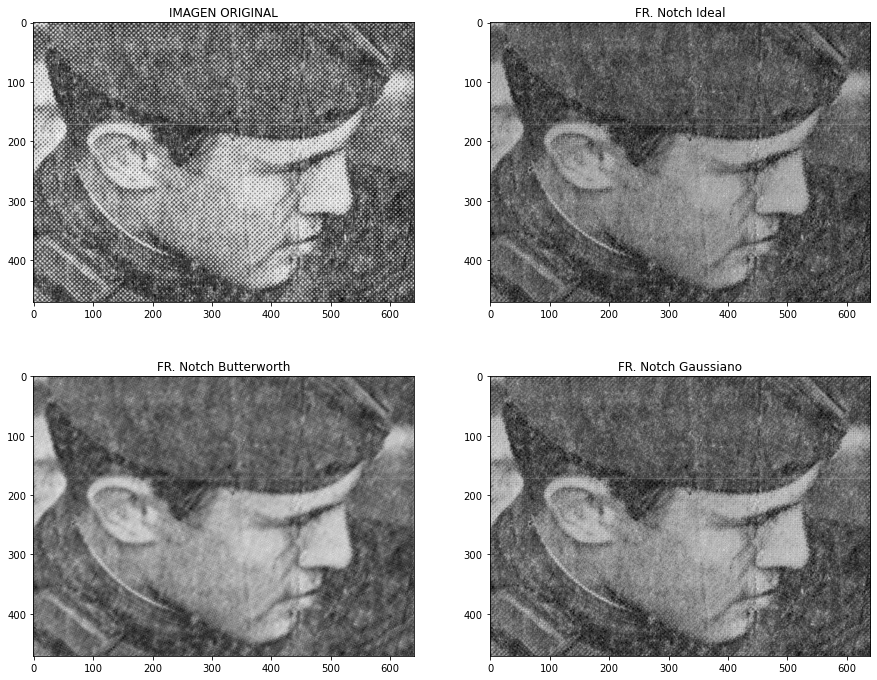

In [70]:
points =[[320,112],[238,173],[403,174],[154,235],[485,236],[236,296],[401,297],[319,358],[322,304],[237,257],[195,235],[318,166],[403,212],[444,236],[72,173],[155,112],[238,51],[320,5],[403,53],[486,112],[567,174],[72,295],[154,357],[236,420],[320,466],[401,420],[485,358],[567,297]]
points = np.asarray(points)
d0=150
plt.figure(1,figsize=(15,15))
plt.subplots_adjust(top=0.75,hspace=0)
plt.subplot(221)
plt.imshow(img, cmap="gray")
plt.title('IMAGEN ORIGINAL')
plt.subplot(222)
plt.title('FR. Notch Ideal')
plt.imshow(IdealNotchFilter(img, points, d0), cmap="gray")
plt.subplot(223)
plt.title('FR. Notch Butterworth')
plt.imshow(ButterworthNotchFilter(img, points, d0, order = 3), cmap="gray")
plt.subplot(224)
plt.title('FR. Notch Gaussiano')
plt.imshow(GaussianNotchFilter(img, points, 70), cmap="gray")
plt.subplots_adjust(hspace=0.1)

En esta ocasion el filtadro de las interferencias es un poco mas complejo debido a que deben tomarse muchos mas puntos del patron, sin embargo se evidencia el funcionamiento de los filtros al trabajar sobre las interferencias principales.

<h1> SEGUNDO PUNTO

En este punto evaluaremos el filtro de Wiener para una imagen degradada con un kernel de convolución tipo “motion” y además con ruido aditivo.

Definimos la función que nos permitira degradar la imagen con un kernel de convolución tipo 'Motion':

In [94]:
def blur(img, mode = 'box', block_size = 3):
    # mode = 'box' or 'gaussian' or 'motion'
    dummy = np.copy(img)
    if mode == 'box':
        h = np.ones((block_size, block_size)) / block_size ** 2
    elif mode == 'gaussian':
        h = gaussian(block_size, block_size / 3).reshape(block_size, 1)
        h = np.dot(h, h.transpose())
        h /= np.sum(h)
    elif mode == 'motion':
        h = np.eye(block_size) / block_size
    dummy = convolve2d(dummy, h, mode = 'same')
    return dummy, h

Definimos la función que nos permitira añadirle ruido aditivo a nuestra imagen:

In [95]:
def gaussian_add(img, sigma = 5):
    dummy = np.copy(img).astype(float)
    gauss = np.random.normal(0, sigma, np.shape(img))
    # Additive Noise
    dummy = np.round(gauss + dummy)
    # Saturate lower bound
    dummy[np.where(dummy < 0)] = 0
    # Saturate upper bound
    dummy[np.where(dummy > 255)] = 255
    return dummy

Para empezar cargamos la imagen con la que trabajaremos:

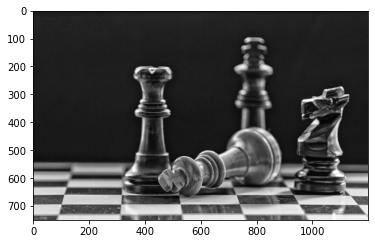

In [153]:
img = cv2.imread("fig/aje.jpg",0)
plt.imshow(img, cmap="gray")

Aplicamos Blur y ruido aditivo a nuestra imagen:

In [163]:
balance = 1000
blur_img, h1 = blur(img,mode = 'motion',block_size = 20)
blur_img = gaussian_add(blur_img, sigma = 40)
blur_img += 0.1 * blur_img.std() * np.random.standard_normal(blur_img.shape)
#gauss_img = gaussian_add(blur_img, sigma = 5)
Wiener_filtered = restoration.wiener(blur_img,h1,balance,clip=False)

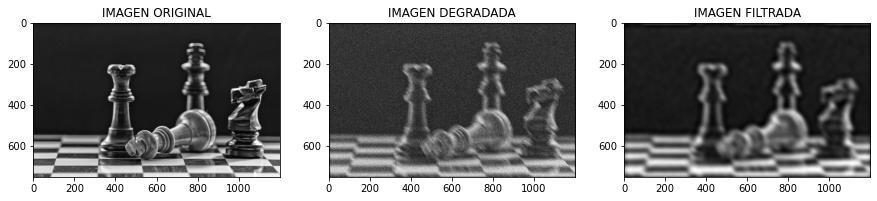

In [164]:
plt.figure(1,figsize=(15,15))
plt.subplot(131).imshow(img, cmap='gray')
plt.title('IMAGEN ORIGINAL')
plt.subplot(132).imshow(blur_img, cmap='gray')
plt.title('IMAGEN DEGRADADA')
plt.subplot(133).imshow(Wiener_filtered, cmap="gray")
plt.title('IMAGEN FILTRADA')
plt.show()

Podemos observar como la imagen degradada tiene la presencia de ruido gaussiano aditivo ademas de haber quedado como una imagen en movimiento, a esta se le aplico el filtro de wiener con el kernel 'Motion', de esta manera podemos observar a la salida que el ruido aditivo se filtro ademas de que la imagen ya no presenta el "movimiento" que tenia.

<h1>TERCER PUNTO

En este punto estudiaremos la función INPAINT que nos brinda opencv, la cual es una clase de algoritmos en visión artificial donde el objetivo es rellenar regiones dentro de una imagen, La región se identifica mediante una máscara binaria, y el llenado se realiza generalmente mediante la propagación de información desde el límite de la región que se debe completar.

La aplicación más común de la pintura de imágenes es la restauración de fotografías antiguas escaneadas. También se utiliza para eliminar pequeños objetos no deseados en una imagen.

In [71]:
img = cv2.imread("fig/foto1.jpg")
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
img1 = cv2.imread("fig/foto1r.jpg")
image1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# convert to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)

Para realizar la aplicación de esta función cargamos una fotografia antigua deteriorada en algunas partes como podemos observar:

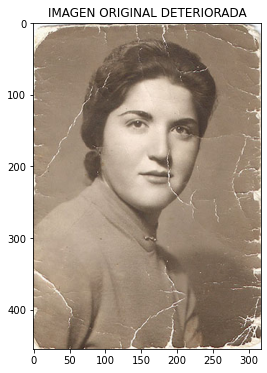

In [76]:
plt.figure(figsize=(10,6))
plt.imshow(image, cmap="gray")
plt.title('IMAGEN ORIGINAL DETERIORADA')
plt.show()

Una vez observada la imagen que queremos restaurar obtenemos la mascara binaria a partir de la información de la imagen, la cual nos servira para realizar el procedimiento.

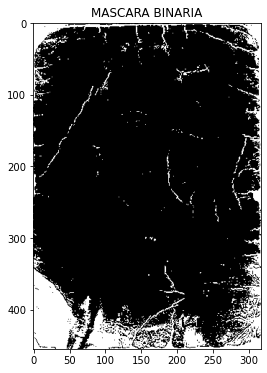

In [77]:
plt.figure(figsize=(10,6))
_, binary = cv2.threshold(cv2.absdiff(gray,gray1), 50, 255, cv2.THRESH_BINARY)
# show it
plt.imshow(binary, cmap="gray")
plt.title('MASCARA BINARIA')
plt.show()

Hacemos uso de la función inpaint la cual tiene como parametros la imagen original, la mascara binaria y el algoritmo de reconstrucción de Alexander Telea o de Navier-Stokes.

Text(0.5, 1.0, 'RESTAURACIÓN ALGORITMO NAVIER-STOCKES')

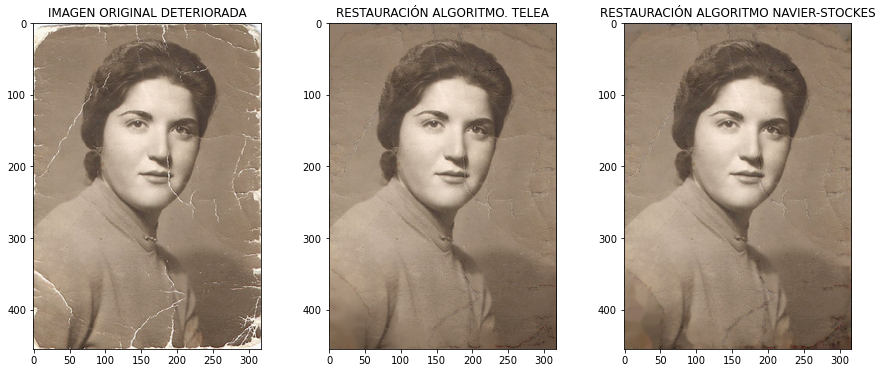

In [83]:
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.imshow(image)
plt.title('IMAGEN ORIGINAL DETERIORADA')
plt.subplot(132)
plt.imshow(cv2.inpaint(image,binary,40,cv2.INPAINT_TELEA))
plt.title('RESTAURACIÓN ALGORITMO. TELEA')
plt.subplot(133)
plt.imshow(cv2.inpaint(image,binary,40,cv2.INPAINT_NS))
plt.title('RESTAURACIÓN ALGORITMO NAVIER-STOCKES')

Como podemos observar la función reconstruye el área de la imagen seleccionada a partir del píxel cercano al límite del área,  con lo cual las deterioraciones se rellenan.

Ahora bien probemos su funcionamiento en una imagen actual pero a color en donde tenemos una zona dañada de la imagen:

In [85]:
img_o = cv2.imread("fig/gato.jpg")
mask = cv2.imread("fig/mask.jpg")
image_o = cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB)
image_m = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
# convert to grayscale
gray_o = cv2.cvtColor(image_o, cv2.COLOR_RGB2GRAY)
gray_m = cv2.cvtColor(image_m, cv2.COLOR_RGB2GRAY)

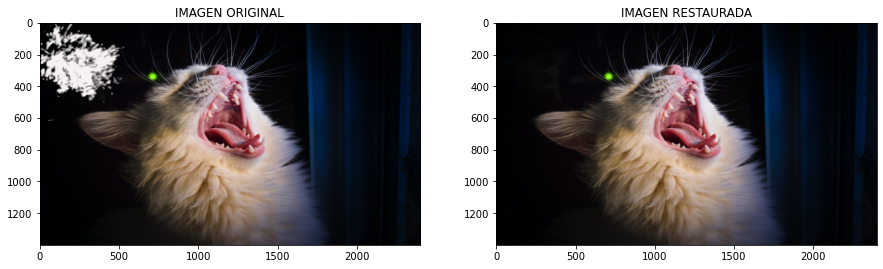

In [86]:
plt.figure(figsize=(15,15))
dst = cv2.inpaint(image_o,gray_m,10,cv2.INPAINT_TELEA)
plt.subplot(121)
plt.title('IMAGEN ORIGINAL')
plt.imshow(image_o)
plt.subplot(122)
plt.title('IMAGEN RESTAURADA')
plt.imshow(dst)

Observamos como el algoritmo practicamente elimino la mancha que tenia nuestra fotografia.